In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%pylab
%matplotlib inline
import os
import math
import time
import tensorflow as tf
from datasets import dataset_utils,cifar10
from tensorflow.contrib import slim

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
dropout_keep_prob=0.8
image_size = 32
step=20000
learning_rate=0.0002
train_dir = '/tmp/cifar10/elu3'

In [3]:
cifar10_data_dir='/media/ramdisk/data/cifar10'

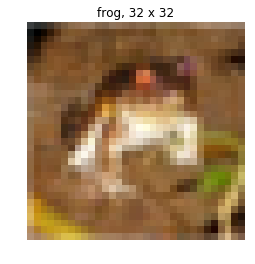

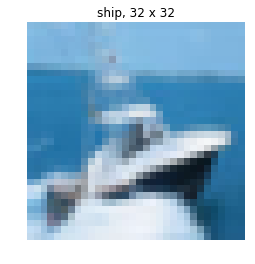

In [4]:
display_step=2

with tf.Graph().as_default(): 
    dataset = cifar10.get_split('train', cifar10_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])

    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(display_step):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()


In [5]:

def cnn_elu(images, num_classes, is_training):
    #https://github.com/agrawalnishant/tensorflow-1/tree/master/tensorflow/contrib/slim 
    ##vgg와  cifarndet을 참조함
    with slim.arg_scope([slim.max_pool2d], stride=2): 

        net = slim.repeat(images, 2, slim.conv2d, 64, [3, 3], scope='conv1',activation_fn=tf.nn.elu)
        net = slim.max_pool2d(net, [2, 2], scope='pool1')
        net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2',activation_fn=tf.nn.elu)
        net = slim.max_pool2d(net, [2, 2], scope='pool2')
        net = slim.repeat(net, 4, slim.conv2d, 256, [3, 3], scope='conv3',activation_fn=tf.nn.elu)
        net = slim.max_pool2d(net, [2, 2], scope='pool3')
        net = slim.repeat(net, 4, slim.conv2d, 512, [3, 3], scope='conv4',activation_fn=tf.nn.elu)
        net = slim.max_pool2d(net, [2, 2], scope='pool4')
       
        net = slim.conv2d(net, 512, [2, 2], padding="VALID", scope='fc6')
        net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                         scope='dropout6')
        net = slim.conv2d(net, 512, [1, 1], scope='fc8', activation_fn=None)
        net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                           scope='dropout7')
        net = slim.conv2d(net, num_classes, [1, 1],
                          activation_fn=None,
                          normalizer_fn=None,
                          scope='fc9')
        
        net = tf.squeeze(net, [1,2],name='fc9/squeezed')
        
        return net

In [6]:
from preprocessing import cifarnet_preprocessing

def load_batch(dataset, batch_size=128, height=image_size, width=image_size, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=128,
        common_queue_min=32)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = cifarnet_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=4,
          capacity=4 * batch_size)
    
    return images, images_raw, labels

In [7]:
%%time
# This might take a few minutes.

print('Will save model to %s' % train_dir)

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)

    dataset = cifar10.get_split('train', cifar10_data_dir)
    images, _, labels = load_batch(dataset)
  
    # Create the model:
    logits =cnn_elu(images, num_classes=dataset.num_classes, is_training=True)
 
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()
    
    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
    
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = slim.learning.create_train_op(total_loss, optimizer)

    # Run the training:
    final_loss = slim.learning.train(
      train_op,
      logdir=train_dir,
      number_of_steps=step, 
          log_every_n_steps=10,
        save_interval_secs=100,
      save_summaries_secs=100)
  
    print('Finished training. Final batch loss %d' % final_loss)

Will save model to /tmp/cifar10/elu3
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/elu3/model.ckpt
INFO:tensorflow:Star

INFO:tensorflow:global step 840: loss = 0.8845 (0.111 sec/step)
INFO:tensorflow:global step 850: loss = 0.7770 (0.106 sec/step)
INFO:tensorflow:global step 860: loss = 0.7795 (0.105 sec/step)
INFO:tensorflow:global step 870: loss = 0.6685 (0.108 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/elu3/model.ckpt
INFO:tensorflow:global_step/sec: 8.797
INFO:tensorflow:Recording summary at step 879.
INFO:tensorflow:global step 880: loss = 0.7113 (0.275 sec/step)
INFO:tensorflow:global step 890: loss = 0.8003 (0.108 sec/step)
INFO:tensorflow:global step 900: loss = 0.6625 (0.103 sec/step)
INFO:tensorflow:global step 910: loss = 0.8465 (0.110 sec/step)
INFO:tensorflow:global step 920: loss = 0.8958 (0.112 sec/step)
INFO:tensorflow:global step 930: loss = 0.7902 (0.106 sec/step)
INFO:tensorflow:global step 940: loss = 0.7692 (0.105 sec/step)
INFO:tensorflow:global step 950: loss = 0.9101 (0.127 sec/step)
INFO:tensorflow:global step 960: loss = 0.8557 (0.104 sec/step)
INFO:tensor

INFO:tensorflow:global step 2060: loss = 0.5406 (0.101 sec/step)
INFO:tensorflow:global step 2070: loss = 0.4337 (0.111 sec/step)
INFO:tensorflow:global step 2080: loss = 0.5300 (0.100 sec/step)
INFO:tensorflow:global step 2090: loss = 0.4572 (0.103 sec/step)
INFO:tensorflow:global step 2100: loss = 0.4929 (0.120 sec/step)
INFO:tensorflow:global step 2110: loss = 0.3463 (0.101 sec/step)
INFO:tensorflow:global step 2120: loss = 0.4723 (0.106 sec/step)
INFO:tensorflow:global step 2130: loss = 0.6378 (0.110 sec/step)
INFO:tensorflow:global step 2140: loss = 0.4197 (0.109 sec/step)
INFO:tensorflow:global step 2150: loss = 0.4215 (0.108 sec/step)
INFO:tensorflow:global step 2160: loss = 0.5010 (0.108 sec/step)
INFO:tensorflow:global step 2170: loss = 0.4469 (0.128 sec/step)
INFO:tensorflow:global step 2180: loss = 0.5002 (0.107 sec/step)
INFO:tensorflow:global step 2190: loss = 0.6132 (0.104 sec/step)
INFO:tensorflow:global step 2200: loss = 0.5448 (0.110 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3300: loss = 0.3357 (0.108 sec/step)
INFO:tensorflow:global step 3310: loss = 0.3137 (0.114 sec/step)
INFO:tensorflow:global step 3320: loss = 0.4071 (0.106 sec/step)
INFO:tensorflow:global step 3330: loss = 0.2324 (0.107 sec/step)
INFO:tensorflow:global step 3340: loss = 0.3127 (0.106 sec/step)
INFO:tensorflow:global step 3350: loss = 0.3020 (0.110 sec/step)
INFO:tensorflow:global step 3360: loss = 0.2979 (0.103 sec/step)
INFO:tensorflow:global step 3370: loss = 0.3076 (0.109 sec/step)
INFO:tensorflow:global step 3380: loss = 0.3697 (0.112 sec/step)
INFO:tensorflow:global step 3390: loss = 0.3376 (0.126 sec/step)
INFO:tensorflow:global step 3400: loss = 0.3941 (0.119 sec/step)
INFO:tensorflow:global step 3410: loss = 0.2873 (0.111 sec/step)
INFO:tensorflow:global step 3420: loss = 0.2810 (0.111 sec/step)
INFO:tensorflow:global step 3430: loss = 0.3501 (0.118 sec/step)
INFO:tensorflow:global step 3440: loss = 0.3738 (0.106 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4520: loss = 0.2368 (0.110 sec/step)
INFO:tensorflow:global step 4530: loss = 0.2167 (0.110 sec/step)
INFO:tensorflow:global step 4540: loss = 0.1939 (0.100 sec/step)
INFO:tensorflow:global step 4550: loss = 0.1182 (0.104 sec/step)
INFO:tensorflow:global step 4560: loss = 0.1900 (0.113 sec/step)
INFO:tensorflow:global step 4570: loss = 0.0842 (0.118 sec/step)
INFO:tensorflow:global step 4580: loss = 0.0818 (0.108 sec/step)
INFO:tensorflow:global step 4590: loss = 0.1700 (0.112 sec/step)
INFO:tensorflow:global step 4600: loss = 0.1504 (0.110 sec/step)
INFO:tensorflow:global step 4610: loss = 0.2483 (0.109 sec/step)
INFO:tensorflow:global step 4620: loss = 0.1913 (0.116 sec/step)
INFO:tensorflow:global step 4630: loss = 0.1290 (0.114 sec/step)
INFO:tensorflow:global step 4640: loss = 0.0789 (0.123 sec/step)
INFO:tensorflow:global step 4650: loss = 0.2440 (0.115 sec/step)
INFO:tensorflow:global step 4660: loss = 0.1084 (0.106 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5760: loss = 0.2192 (0.125 sec/step)
INFO:tensorflow:global step 5770: loss = 0.1272 (0.111 sec/step)
INFO:tensorflow:global step 5780: loss = 0.1060 (0.111 sec/step)
INFO:tensorflow:global step 5790: loss = 0.1086 (0.105 sec/step)
INFO:tensorflow:global step 5800: loss = 0.1793 (0.113 sec/step)
INFO:tensorflow:global step 5810: loss = 0.0602 (0.108 sec/step)
INFO:tensorflow:global step 5820: loss = 0.1446 (0.107 sec/step)
INFO:tensorflow:global step 5830: loss = 0.0949 (0.109 sec/step)
INFO:tensorflow:global step 5840: loss = 0.0433 (0.112 sec/step)
INFO:tensorflow:global step 5850: loss = 0.0990 (0.121 sec/step)
INFO:tensorflow:global step 5860: loss = 0.1618 (0.108 sec/step)
INFO:tensorflow:global step 5870: loss = 0.1689 (0.105 sec/step)
INFO:tensorflow:global step 5880: loss = 0.2588 (0.113 sec/step)
INFO:tensorflow:global step 5890: loss = 0.0925 (0.113 sec/step)
INFO:tensorflow:global step 5900: loss = 0.1369 (0.109 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7000: loss = 0.0736 (0.105 sec/step)
INFO:tensorflow:global step 7010: loss = 0.1912 (0.121 sec/step)
INFO:tensorflow:global step 7020: loss = 0.0208 (0.109 sec/step)
INFO:tensorflow:global step 7030: loss = 0.2314 (0.106 sec/step)
INFO:tensorflow:global step 7040: loss = 0.0492 (0.104 sec/step)
INFO:tensorflow:global step 7050: loss = 0.1002 (0.100 sec/step)
INFO:tensorflow:global step 7060: loss = 0.0995 (0.115 sec/step)
INFO:tensorflow:global step 7070: loss = 0.0255 (0.116 sec/step)
INFO:tensorflow:global step 7080: loss = 0.0628 (0.121 sec/step)
INFO:tensorflow:global step 7090: loss = 0.1124 (0.108 sec/step)
INFO:tensorflow:global step 7100: loss = 0.0956 (0.103 sec/step)
INFO:tensorflow:global step 7110: loss = 0.0337 (0.104 sec/step)
INFO:tensorflow:global step 7120: loss = 0.0421 (0.110 sec/step)
INFO:tensorflow:global step 7130: loss = 0.0678 (0.105 sec/step)
INFO:tensorflow:global step 7140: loss = 0.0348 (0.113 sec/step)
INFO:tensorflow:Saving ch

INFO:tensorflow:global step 8220: loss = 0.1088 (0.107 sec/step)
INFO:tensorflow:global step 8230: loss = 0.1013 (0.100 sec/step)
INFO:tensorflow:global step 8240: loss = 0.1677 (0.112 sec/step)
INFO:tensorflow:global step 8250: loss = 0.1282 (0.118 sec/step)
INFO:tensorflow:global step 8260: loss = 0.0459 (0.106 sec/step)
INFO:tensorflow:global step 8270: loss = 0.0367 (0.113 sec/step)
INFO:tensorflow:global step 8280: loss = 0.0332 (0.137 sec/step)
INFO:tensorflow:global step 8290: loss = 0.0883 (0.109 sec/step)
INFO:tensorflow:global step 8300: loss = 0.0376 (0.114 sec/step)
INFO:tensorflow:global step 8310: loss = 0.0290 (0.110 sec/step)
INFO:tensorflow:global step 8320: loss = 0.0144 (0.110 sec/step)
INFO:tensorflow:global step 8330: loss = 0.1014 (0.113 sec/step)
INFO:tensorflow:global step 8340: loss = 0.0948 (0.107 sec/step)
INFO:tensorflow:global step 8350: loss = 0.0759 (0.110 sec/step)
INFO:tensorflow:global step 8360: loss = 0.0435 (0.103 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9470: loss = 0.0513 (0.115 sec/step)
INFO:tensorflow:global step 9480: loss = 0.0609 (0.103 sec/step)
INFO:tensorflow:global step 9490: loss = 0.1585 (0.110 sec/step)
INFO:tensorflow:global step 9500: loss = 0.0889 (0.110 sec/step)
INFO:tensorflow:global step 9510: loss = 0.0852 (0.113 sec/step)
INFO:tensorflow:global step 9520: loss = 0.0305 (0.108 sec/step)
INFO:tensorflow:global step 9530: loss = 0.0962 (0.108 sec/step)
INFO:tensorflow:global step 9540: loss = 0.0536 (0.110 sec/step)
INFO:tensorflow:global step 9550: loss = 0.0179 (0.105 sec/step)
INFO:tensorflow:global step 9560: loss = 0.0353 (0.115 sec/step)
INFO:tensorflow:global step 9570: loss = 0.0518 (0.113 sec/step)
INFO:tensorflow:global step 9580: loss = 0.0372 (0.100 sec/step)
INFO:tensorflow:global step 9590: loss = 0.0176 (0.108 sec/step)
INFO:tensorflow:global step 9600: loss = 0.0874 (0.106 sec/step)
INFO:tensorflow:global step 9610: loss = 0.0484 (0.107 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/elu3/model.ckpt
INFO:tensorflow:Recording summary at step 10708.
INFO:tensorflow:global step 10710: loss = 0.0383 (0.162 sec/step)
INFO:tensorflow:global step 10720: loss = 0.0783 (0.109 sec/step)
INFO:tensorflow:global step 10730: loss = 0.0531 (0.115 sec/step)
INFO:tensorflow:global step 10740: loss = 0.0734 (0.111 sec/step)
INFO:tensorflow:global step 10750: loss = 0.1855 (0.102 sec/step)
INFO:tensorflow:global step 10760: loss = 0.0538 (0.112 sec/step)
INFO:tensorflow:global step 10770: loss = 0.0338 (0.115 sec/step)
INFO:tensorflow:global step 10780: loss = 0.0341 (0.103 sec/step)
INFO:tensorflow:global step 10790: loss = 0.1079 (0.115 sec/step)
INFO:tensorflow:global step 10800: loss = 0.0191 (0.102 sec/step)
INFO:tensorflow:global step 10810: loss = 0.0177 (0.102 sec/step)
INFO:tensorflow:global step 10820: loss = 0.0455 (0.104 sec/step)
INFO:tensorflow:global step 10830: loss = 0.0551 (0.103 sec/step)
INFO:tensorflow:global

INFO:tensorflow:global step 11920: loss = 0.1472 (0.138 sec/step)
INFO:tensorflow:global step 11930: loss = 0.0971 (0.112 sec/step)
INFO:tensorflow:global step 11940: loss = 0.0076 (0.107 sec/step)
INFO:tensorflow:global step 11950: loss = 0.0658 (0.113 sec/step)
INFO:tensorflow:global step 11960: loss = 0.1794 (0.122 sec/step)
INFO:tensorflow:global step 11970: loss = 0.0390 (0.107 sec/step)
INFO:tensorflow:global step 11980: loss = 0.0643 (0.111 sec/step)
INFO:tensorflow:global step 11990: loss = 0.0871 (0.110 sec/step)
INFO:tensorflow:global step 12000: loss = 0.0599 (0.108 sec/step)
INFO:tensorflow:global step 12010: loss = 0.0189 (0.110 sec/step)
INFO:tensorflow:global step 12020: loss = 0.0616 (0.108 sec/step)
INFO:tensorflow:global step 12030: loss = 0.1348 (0.111 sec/step)
INFO:tensorflow:global step 12040: loss = 0.0531 (0.111 sec/step)
INFO:tensorflow:global step 12050: loss = 0.0369 (0.103 sec/step)
INFO:tensorflow:global step 12060: loss = 0.0084 (0.121 sec/step)
INFO:tenso

INFO:tensorflow:global step 13150: loss = 0.0287 (0.106 sec/step)
INFO:tensorflow:global step 13160: loss = 0.0750 (0.102 sec/step)
INFO:tensorflow:global step 13170: loss = 0.0504 (0.114 sec/step)
INFO:tensorflow:global step 13180: loss = 0.0219 (0.112 sec/step)
INFO:tensorflow:global step 13190: loss = 0.0743 (0.117 sec/step)
INFO:tensorflow:global step 13200: loss = 0.0137 (0.112 sec/step)
INFO:tensorflow:global step 13210: loss = 0.0645 (0.106 sec/step)
INFO:tensorflow:global step 13220: loss = 0.0063 (0.108 sec/step)
INFO:tensorflow:global step 13230: loss = 0.0109 (0.114 sec/step)
INFO:tensorflow:global step 13240: loss = 0.0189 (0.114 sec/step)
INFO:tensorflow:global step 13250: loss = 0.0222 (0.108 sec/step)
INFO:tensorflow:global step 13260: loss = 0.0785 (0.111 sec/step)
INFO:tensorflow:global step 13270: loss = 0.0624 (0.112 sec/step)
INFO:tensorflow:global step 13280: loss = 0.0234 (0.103 sec/step)
INFO:tensorflow:global step 13290: loss = 0.0476 (0.101 sec/step)
INFO:tenso

INFO:tensorflow:global step 14360: loss = 0.0628 (0.104 sec/step)
INFO:tensorflow:global step 14370: loss = 0.1206 (0.108 sec/step)
INFO:tensorflow:global step 14380: loss = 0.0380 (0.107 sec/step)
INFO:tensorflow:global step 14390: loss = 0.0154 (0.123 sec/step)
INFO:tensorflow:global step 14400: loss = 0.0160 (0.108 sec/step)
INFO:tensorflow:global step 14410: loss = 0.0493 (0.122 sec/step)
INFO:tensorflow:global step 14420: loss = 0.0508 (0.115 sec/step)
INFO:tensorflow:global step 14430: loss = 0.0319 (0.117 sec/step)
INFO:tensorflow:global step 14440: loss = 0.0290 (0.103 sec/step)
INFO:tensorflow:global step 14450: loss = 0.0130 (0.100 sec/step)
INFO:tensorflow:global step 14460: loss = 0.0436 (0.108 sec/step)
INFO:tensorflow:global step 14470: loss = 0.0243 (0.109 sec/step)
INFO:tensorflow:global step 14480: loss = 0.0977 (0.115 sec/step)
INFO:tensorflow:global step 14490: loss = 0.0931 (0.112 sec/step)
INFO:tensorflow:global step 14500: loss = 0.0931 (0.107 sec/step)
INFO:tenso

INFO:tensorflow:global step 15590: loss = 0.0794 (0.108 sec/step)
INFO:tensorflow:global step 15600: loss = 0.0604 (0.109 sec/step)
INFO:tensorflow:global step 15610: loss = 0.0270 (0.105 sec/step)
INFO:tensorflow:global step 15620: loss = 0.0081 (0.105 sec/step)
INFO:tensorflow:global step 15630: loss = 0.0567 (0.118 sec/step)
INFO:tensorflow:global step 15640: loss = 0.0905 (0.104 sec/step)
INFO:tensorflow:global step 15650: loss = 0.0861 (0.110 sec/step)
INFO:tensorflow:global step 15660: loss = 0.0547 (0.110 sec/step)
INFO:tensorflow:global step 15670: loss = 0.0060 (0.112 sec/step)
INFO:tensorflow:global step 15680: loss = 0.0150 (0.118 sec/step)
INFO:tensorflow:global step 15690: loss = 0.0493 (0.117 sec/step)
INFO:tensorflow:global step 15700: loss = 0.1444 (0.112 sec/step)
INFO:tensorflow:global step 15710: loss = 0.0546 (0.104 sec/step)
INFO:tensorflow:global step 15720: loss = 0.0232 (0.112 sec/step)
INFO:tensorflow:global step 15730: loss = 0.0321 (0.106 sec/step)
INFO:tenso

INFO:tensorflow:global step 16820: loss = 0.0112 (0.112 sec/step)
INFO:tensorflow:global step 16830: loss = 0.0245 (0.127 sec/step)
INFO:tensorflow:global step 16840: loss = 0.0390 (0.115 sec/step)
INFO:tensorflow:global step 16850: loss = 0.0254 (0.121 sec/step)
INFO:tensorflow:global step 16860: loss = 0.0622 (0.120 sec/step)
INFO:tensorflow:global step 16870: loss = 0.0684 (0.106 sec/step)
INFO:tensorflow:global step 16880: loss = 0.1761 (0.103 sec/step)
INFO:tensorflow:global step 16890: loss = 0.2287 (0.120 sec/step)
INFO:tensorflow:global step 16900: loss = 0.0722 (0.105 sec/step)
INFO:tensorflow:global step 16910: loss = 0.0144 (0.118 sec/step)
INFO:tensorflow:global step 16920: loss = 0.0387 (0.111 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/elu3/model.ckpt
INFO:tensorflow:Recording summary at step 16925.
INFO:tensorflow:global step 16930: loss = 0.0286 (0.108 sec/step)
INFO:tensorflow:global step 16940: loss = 0.0104 (0.114 sec/step)
INFO:tensorflow:global

INFO:tensorflow:global step 18030: loss = 0.0581 (0.108 sec/step)
INFO:tensorflow:global step 18040: loss = 0.0288 (0.109 sec/step)
INFO:tensorflow:global step 18050: loss = 0.0243 (0.123 sec/step)
INFO:tensorflow:global step 18060: loss = 0.0013 (0.110 sec/step)
INFO:tensorflow:global step 18070: loss = 0.0110 (0.104 sec/step)
INFO:tensorflow:global step 18080: loss = 0.0040 (0.110 sec/step)
INFO:tensorflow:global step 18090: loss = 0.0096 (0.118 sec/step)
INFO:tensorflow:global step 18100: loss = 0.0023 (0.112 sec/step)
INFO:tensorflow:global step 18110: loss = 0.0359 (0.105 sec/step)
INFO:tensorflow:global step 18120: loss = 0.0194 (0.117 sec/step)
INFO:tensorflow:global step 18130: loss = 0.0972 (0.113 sec/step)
INFO:tensorflow:global step 18140: loss = 0.0240 (0.101 sec/step)
INFO:tensorflow:global step 18150: loss = 0.0823 (0.113 sec/step)
INFO:tensorflow:global step 18160: loss = 0.1382 (0.106 sec/step)
INFO:tensorflow:global step 18170: loss = 0.0435 (0.107 sec/step)
INFO:tenso

INFO:tensorflow:global step 19260: loss = 0.0144 (0.104 sec/step)
INFO:tensorflow:global step 19270: loss = 0.1771 (0.109 sec/step)
INFO:tensorflow:global step 19280: loss = 0.1088 (0.111 sec/step)
INFO:tensorflow:global step 19290: loss = 0.0333 (0.107 sec/step)
INFO:tensorflow:global step 19300: loss = 0.0253 (0.118 sec/step)
INFO:tensorflow:global step 19310: loss = 0.0356 (0.102 sec/step)
INFO:tensorflow:global step 19320: loss = 0.0165 (0.105 sec/step)
INFO:tensorflow:global step 19330: loss = 0.0016 (0.115 sec/step)
INFO:tensorflow:global step 19340: loss = 0.0105 (0.110 sec/step)
INFO:tensorflow:global step 19350: loss = 0.0449 (0.104 sec/step)
INFO:tensorflow:global step 19360: loss = 0.0107 (0.107 sec/step)
INFO:tensorflow:global step 19370: loss = 0.0195 (0.124 sec/step)
INFO:tensorflow:global step 19380: loss = 0.0092 (0.112 sec/step)
INFO:tensorflow:global step 19390: loss = 0.0223 (0.117 sec/step)
INFO:tensorflow:global step 19400: loss = 0.0349 (0.119 sec/step)
INFO:tenso

In [8]:
%%time

# This might take a few minutes.
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.DEBUG)
    
    dataset = cifar10.get_split('test', cifar10_data_dir)
    images, _, labels = load_batch(dataset)
    
    logits = cnn_elu(images, num_classes=dataset.num_classes, is_training=False)
    predictions = tf.argmax(logits, 1)
    
    # Define the metrics:
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'eval/mse':slim.metrics.streaming_mean_squared_error(predictions, labels),
        'eval/Accuracy': slim.metrics.streaming_accuracy(predictions, labels),
        'eval/TruePositives': slim.metrics.streaming_true_positives(predictions, labels),        
        'eval/TrueNegatives': slim.metrics.streaming_true_negatives(predictions, labels),
        'eval/FalsePositives': slim.metrics.streaming_false_positives(predictions, labels),
        'eval/FalseNegatives': slim.metrics.streaming_false_negatives(predictions, labels),
        'eval/Recall5': slim.metrics.streaming_sparse_recall_at_k(logits, labels, 5),
    })

    print('Running evaluation Loop...')
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    metric_values = slim.evaluation.evaluate_once(
        master='',
        checkpoint_path=checkpoint_path,
        logdir=train_dir,
        eval_op=list(names_to_updates.values()),
        final_op=list(names_to_values.values())
    )

    names_to_values = dict(zip(names_to_values.keys(), metric_values))
    for name in names_to_values:
        print('%s: %f' % (name, names_to_values[name]))


Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the inputs of labels and predictions have been switched.
Running evaluation Loop...
INFO:tensorflow:Starting evaluation at 2017-12-09-05:48:51
INFO:tensorflow:Restoring parameters from /tmp/cifar10/elu3/model.ckpt-20000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-09-05:48:52
eval/TrueNegatives: 11.000000
eval/Recall5: 0.984375
eval/FalsePositives: 3.000000
eval/FalseNegatives: 5.000000
eval/TruePositives: 109.000000
eval/mse: 4.453125
eval/Accuracy: 0.789062
CPU times: user 1.92 s, sys: 336 ms, total: 2.26 s
Wall time: 1.37 s


INFO:tensorflow:Restoring parameters from /tmp/cifar10/elu3/model.ckpt-20000


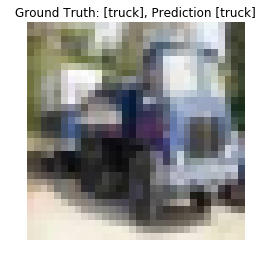

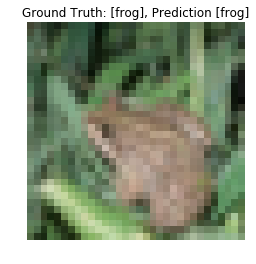

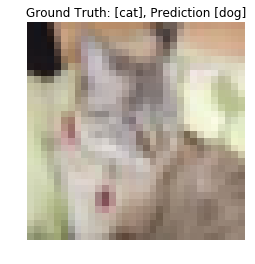

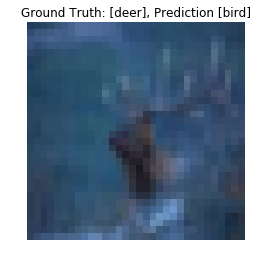

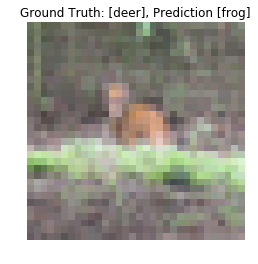

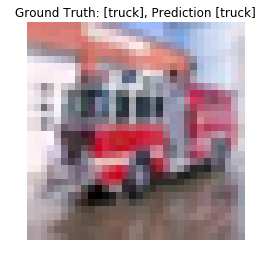

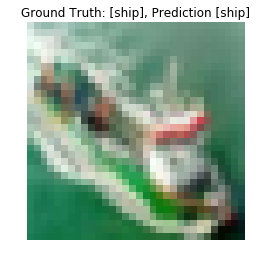

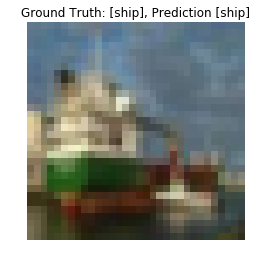

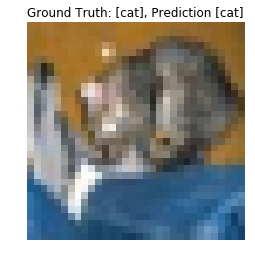

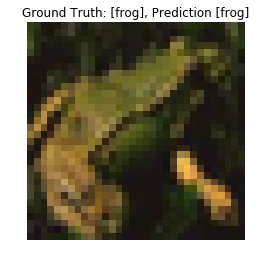

CPU times: user 3.79 s, sys: 1.74 s, total: 5.54 s
Wall time: 1.9 s


In [9]:
%%time
batch_size = 10
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = cifar10.get_split('test',cifar10_data_dir)
    images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    logits = cnn_elu(images, num_classes=dataset.num_classes, is_training=True)
    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.local_variables_initializer())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
    
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = dataset.labels_to_names[predicted_label]
                true_name = dataset.labels_to_names[true_label]
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()